<a href="https://colab.research.google.com/github/NaokiDohi/senior_thesis/blob/master/sin_QRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# create sin wave

In [3]:
def sin(x, T=100):
    return np.sin(2.0 * np.pi * x / T)

# sin波にノイズを付与する
def toy_problem(T=100, ampl=0.05):
    x = np.arange(0, 2 * T + 1)
    noise = ampl * np.random.uniform(low=-1.0, high=1.0, size=len(x))
    return sin(x) + noise

f = toy_problem()

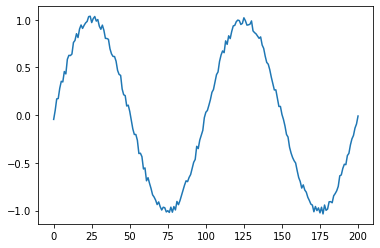

In [4]:
plt.plot(np.arange(201),f)

In [5]:
def make_dataset(low_data, n_prev=100):

    data, target = [], []
    maxlen = 25

    for i in range(len(low_data)-maxlen):
        data.append(low_data[i:i + maxlen])
        target.append(low_data[i + maxlen])

    re_data = np.array(data).reshape(len(data), maxlen, 1)
    re_target = np.array(target).reshape(len(data), 1)

    return re_data, re_target


#g -> 学習データ，h -> 学習ラベル
g, h = make_dataset(f)

In [6]:
g.shape

(176, 25, 1)

In [7]:
h.shape

(176, 1)

# QRNN class

In [8]:
from __future__ import absolute_import
import numpy as np

from keras import backend as K
from keras import activations, initializers, regularizers, constraints
from keras.layers import Layer, InputSpec

from keras.utils.conv_utils import conv_output_length

import theano
import theano.tensor as T


def _dropout(x, level, noise_shape=None, seed=None):
    x = K.dropout(x, level, noise_shape, seed)
    x *= (1. - level) # compensate for the scaling by the dropout
    return x


class QRNN(Layer):
    '''Quasi RNN
    # Arguments
        units: dimension of the internal projections and the final output.
    # References
        - [Quasi-recurrent Neural Networks](http://arxiv.org/abs/1611.01576)
    '''
    def __init__(self, units, window_size=2, stride=1,
                 return_sequences=False, go_backwards=False, 
                 stateful=False, unroll=False, activation='tanh',
                 kernel_initializer='uniform', bias_initializer='zero',
                 kernel_regularizer=None, bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None, bias_constraint=None, 
                 dropout=0, use_bias=True, input_dim=None, input_length=None,
                 **kwargs):
        self.return_sequences = return_sequences
        self.go_backwards = go_backwards
        self.stateful = stateful
        self.unroll = unroll

        self.units = units 
        self.window_size = window_size
        self.strides = (stride, 1)

        self.use_bias = use_bias
        self.activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

        self.recurrent_dropout = 0 #not used, added to maintain compatibility with keras.Bidirectional
        self.dropout = dropout
        self.supports_masking = True
        self.input_spec = [InputSpec(ndim=3)]
        self.input_dim = input_dim
        self.input_length = input_length
        if self.input_dim:
            kwargs['input_shape'] = (self.input_length, self.input_dim)
        super(QRNN, self).__init__(**kwargs)

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None
        self.input_dim = input_shape[2]
        self.input_spec = InputSpec(shape=(batch_size, None, self.input_dim))
        self.state_spec = InputSpec(shape=(batch_size, self.units))

        self.states = [None]
        if self.stateful:
            self.reset_states()

        kernel_shape = (self.window_size, 1, self.input_dim, self.units * 3)
        self.kernel = self.add_weight(name='kernel',
                                      shape=kernel_shape,
                                      initializer=self.kernel_initializer,
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(name='bias', 
                                        shape=(self.units * 3,),
                                        initializer=self.bias_initializer,
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)

        self.built = True

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        length = input_shape[1]
        if length:
            length = conv_output_length(length + self.window_size - 1,
                                        self.window_size, 'valid',
                                        self.strides[0])
        if self.return_sequences:
            return (input_shape[0], length, self.units)
        else:
            return (input_shape[0], self.units)

    def compute_mask(self, inputs, mask):
        if self.return_sequences:
            return mask
        else:
            return None

    def get_initial_states(self, inputs):
        # build an all-zero tensor of shape (samples, units)
        initial_state = K.zeros_like(inputs)  # (samples, timesteps, input_dim)
        initial_state = K.sum(initial_state, axis=(1, 2))  # (samples,)
        initial_state = K.expand_dims(initial_state)  # (samples, 1)
        initial_state = K.tile(initial_state, [1, self.units])  # (samples, units)
        initial_states = [initial_state for _ in range(len(self.states))]
        return initial_states

    def reset_states(self, states=None):
        if not self.stateful:
            raise AttributeError('Layer must be stateful.')
        if not self.input_spec:
            raise RuntimeError('Layer has never been called '
                               'and thus has no states.')

        batch_size = self.input_spec.shape[0]
        if not batch_size:
            raise ValueError('If a QRNN is stateful, it needs to know '
                             'its batch size. Specify the batch size '
                             'of your input tensors: \n'
                             '- If using a Sequential model, '
                             'specify the batch size by passing '
                             'a `batch_input_shape` '
                             'argument to your first layer.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a '
                             '`batch_shape` argument to your Input layer.')

        if self.states[0] is None:
            self.states = [K.zeros((batch_size, self.units))
                           for _ in self.states]
        elif states is None:
            for state in self.states:
                K.set_value(state, np.zeros((batch_size, self.units)))
        else:
            if not isinstance(states, (list, tuple)):
                states = [states]
            if len(states) != len(self.states):
                raise ValueError('Layer ' + self.name + ' expects ' +
                                 str(len(self.states)) + ' states, '
                                 'but it received ' + str(len(states)) +
                                 'state values. Input received: ' +
                                 str(states))
            for index, (value, state) in enumerate(zip(states, self.states)):
                if value.shape != (batch_size, self.units):
                    raise ValueError('State ' + str(index) +
                                     ' is incompatible with layer ' +
                                     self.name + ': expected shape=' +
                                     str((batch_size, self.units)) +
                                     ', found shape=' + str(value.shape))
                K.set_value(state, value)

    def __call__(self, inputs, initial_state=None, **kwargs):
        # If `initial_state` is specified,
        # and if it a Keras tensor,
        # then add it to the inputs and temporarily
        # modify the input spec to include the state.
        if initial_state is not None:
            if hasattr(initial_state, '_keras_history'):
                # Compute the full input spec, including state
                input_spec = self.input_spec
                state_spec = self.state_spec
                if not isinstance(state_spec, list):
                    state_spec = [state_spec]
                self.input_spec = [input_spec] + state_spec

                # Compute the full inputs, including state
                if not isinstance(initial_state, (list, tuple)):
                    initial_state = [initial_state]
                inputs = [inputs] + list(initial_state)

                # Perform the call
                output = super(QRNN, self).__call__(inputs, **kwargs)

                # Restore original input spec
                self.input_spec = input_spec
                return output
            else:
                kwargs['initial_state'] = initial_state
        return super(QRNN, self).__call__(inputs, **kwargs)

    def call(self, inputs, mask=None, initial_state=None, training=None):
        # input shape: `(samples, time (padded with zeros), input_dim)`
        # note that the .build() method of subclasses MUST define
        # self.input_spec and self.state_spec with complete input shapes.
        if isinstance(inputs, list):
            initial_states = inputs[1:]
            inputs = inputs[0]
        elif initial_state is not None:
            pass
        elif self.stateful:
            initial_states = self.states
        else:
            initial_states = self.get_initial_states(inputs)

        if len(initial_states) != len(self.states):
            raise ValueError('Layer has ' + str(len(self.states)) +
                             ' states but was passed ' +
                             str(len(initial_states)) +
                             ' initial states.')
        input_shape = K.int_shape(inputs)
        if self.unroll and input_shape[1] is None:
            raise ValueError('Cannot unroll a RNN if the '
                             'time dimension is undefined. \n'
                             '- If using a Sequential model, '
                             'specify the time dimension by passing '
                             'an `input_shape` or `batch_input_shape` '
                             'argument to your first layer. If your '
                             'first layer is an Embedding, you can '
                             'also use the `input_length` argument.\n'
                             '- If using the functional API, specify '
                             'the time dimension by passing a `shape` '
                             'or `batch_shape` argument to your Input layer.')
        constants = self.get_constants(inputs, training=None)
        preprocessed_input = self.preprocess_input(inputs, training=None)

        last_output, outputs, states = K.rnn(self.step, preprocessed_input,
                                            initial_states,
                                            go_backwards=self.go_backwards,
                                            mask=mask,
                                            constants=constants,
                                            unroll=self.unroll,
                                            input_length=input_shape[1])
        if self.stateful:
            updates = []
            for i in range(len(states)):
                updates.append((self.states[i], states[i]))
            self.add_update(updates, inputs)

        # Properly set learning phase
        if 0 < self.dropout < 1:
            last_output._uses_learning_phase = True
            outputs._uses_learning_phase = True

        if self.return_sequences:
            return outputs
        else:
            return last_output

    def preprocess_input(self, inputs, training=None):
        if self.window_size > 1:
            inputs = K.temporal_padding(inputs, (self.window_size-1, 0))
        inputs = K.expand_dims(inputs, 2)  # add a dummy dimension

        output = K.conv2d(inputs, self.kernel, strides=self.strides,
                          padding='valid',
                          data_format='channels_last')
        output = K.squeeze(output, 2)  # remove the dummy dimension
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')

        if self.dropout is not None and 0. < self.dropout < 1.:
            z = output[:, :, :self.units]
            f = output[:, :, self.units:2 * self.units]
            o = output[:, :, 2 * self.units:]
            f = K.in_train_phase(1 - _dropout(1 - f, self.dropout), f, training=training)
            return K.concatenate([z, f, o], -1)
        else:
            return output

    def step(self, inputs, states):
        prev_output = states[0]

        z = inputs[:, :self.units]
        f = inputs[:, self.units:2 * self.units]
        o = inputs[:, 2 * self.units:]

        z = self.activation(z)
        f = f if self.dropout is not None and 0. < self.dropout < 1. else K.sigmoid(f)
        o = K.sigmoid(o)

        output = f * prev_output + (1 - f) * z
        output = o * output

        return output, [output]

    def get_constants(self, inputs, training=None):
        return []
 
    def get_config(self):
        config = {'units': self.units,
                  'window_size': self.window_size,
                  'stride': self.strides[0],
                  'return_sequences': self.return_sequences,
                  'go_backwards': self.go_backwards,
                  'stateful': self.stateful,
                  'unroll': self.unroll,
                  'use_bias': self.use_bias,
                  'dropout': self.dropout,
                  'activation': activations.serialize(self.activation),
                  'kernel_initializer': initializers.serialize(self.kernel_initializer),
                  'bias_initializer': initializers.serialize(self.bias_initializer),
                  'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
                  'bias_regularizer': regularizers.serialize(self.bias_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'kernel_constraint': constraints.serialize(self.kernel_constraint),
                  'bias_constraint': constraints.serialize(self.bias_constraint),
                  'input_dim': self.input_dim,
                  'input_length': self.input_length}
        base_config = super(QRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [9]:
length_of_sequence = g.shape[1] 
in_out_neurons = 1
#n_hidden = 300
window=25
model = Sequential()
model.add(QRNN(32,batch_input_shape=(None, window, in_out_neurons),window_size=25,dropout=0.5))
model.add(Dense(in_out_neurons))
model.add(Activation("linear"))
optimizer = Adam(lr=0.001)
model.compile(loss="mean_squared_error", optimizer=optimizer)# optimizer="rmsprop"

In [10]:
#early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
epochs=200#200
history = model.fit(g, h, batch_size=1, epochs=epochs, validation_split=0.1, verbose=2)#32

Epoch 1/200
158/158 - 1s - loss: 0.0865 - val_loss: 0.0919
Epoch 2/200
158/158 - 1s - loss: 0.0076 - val_loss: 0.0261
Epoch 3/200
158/158 - 1s - loss: 0.0086 - val_loss: 0.0197
Epoch 4/200
158/158 - 1s - loss: 0.0092 - val_loss: 0.0371
Epoch 5/200
158/158 - 1s - loss: 0.0081 - val_loss: 0.0458
Epoch 6/200
158/158 - 1s - loss: 0.0076 - val_loss: 0.0844
Epoch 7/200
158/158 - 1s - loss: 0.0082 - val_loss: 0.0575
Epoch 8/200
158/158 - 1s - loss: 0.0078 - val_loss: 0.0492
Epoch 9/200
158/158 - 1s - loss: 0.0077 - val_loss: 0.0681
Epoch 10/200
158/158 - 1s - loss: 0.0084 - val_loss: 0.0710
Epoch 11/200
158/158 - 1s - loss: 0.0066 - val_loss: 0.0129
Epoch 12/200
158/158 - 1s - loss: 0.0099 - val_loss: 0.0335
Epoch 13/200
158/158 - 1s - loss: 0.0064 - val_loss: 0.0266
Epoch 14/200
158/158 - 1s - loss: 0.0063 - val_loss: 0.0427
Epoch 15/200
158/158 - 1s - loss: 0.0078 - val_loss: 0.0191
Epoch 16/200
158/158 - 1s - loss: 0.0081 - val_loss: 0.0407
Epoch 17/200
158/158 - 1s - loss: 0.0055 - val_lo

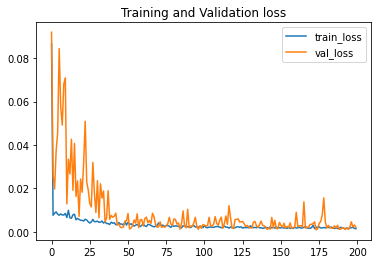

In [12]:
# === 学習推移の可視化 ===
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(np.arange(len(train_loss)), train_loss, label="train_loss")
plt.plot(np.arange(len(val_loss)), val_loss, label="val_loss")
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [13]:
predicted_train_data = model.predict(g)

No handles with labels found to put in legend.


[]

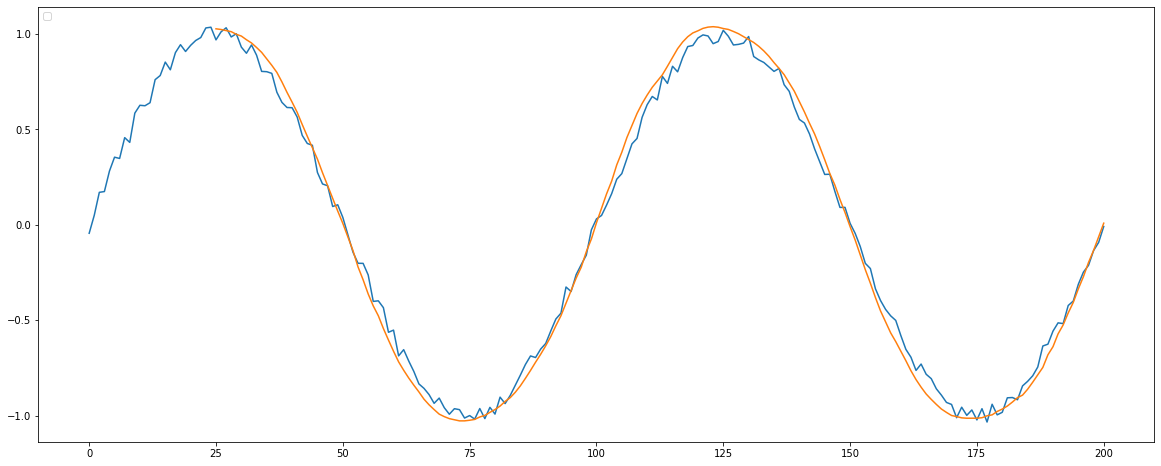

In [14]:
plt.figure(figsize=(20,8))
plt.legend(loc='upper left')
plt.plot(np.arange(201),f,label='original')
plt.plot(np.arange(176)+25,predicted_train_data,label='past_predict')
plt.plot()

In [15]:
future_test = g[-1].T
# 1つの学習データの時間の長さ -> 25
time_length = future_test.shape[1]
# 未来の予測データを保存していく変数
future_result = np.empty((0))

# 未来予想
for step2 in range(400):

    test_data = np.reshape(future_test, (1, time_length, 1))
    batch_predict = model.predict(test_data)

    future_test = np.delete(future_test, 0)
    future_test = np.append(future_test, batch_predict)

    future_result = np.append(future_result, batch_predict)

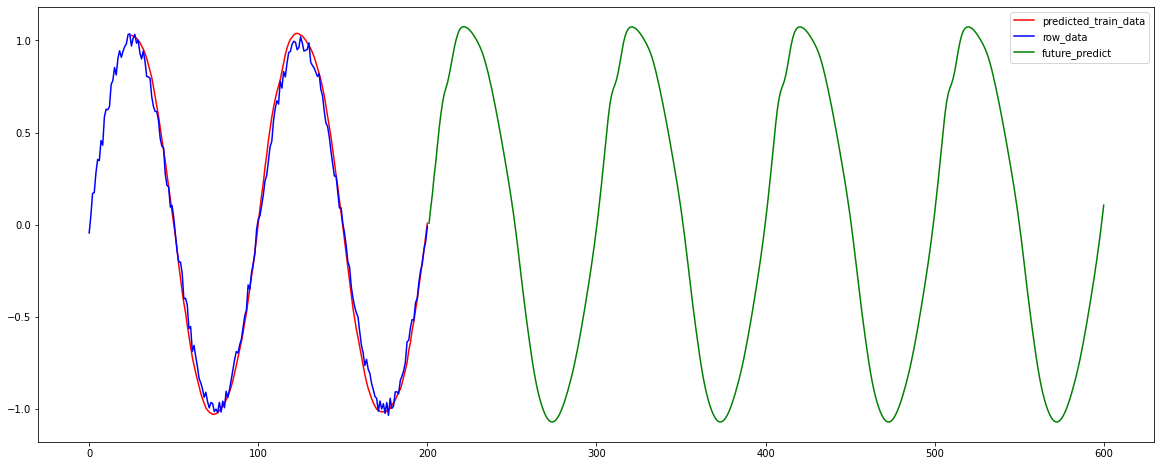

In [18]:
# sin波をプロット
plt.figure(figsize=(20,8))
plt.plot(range(25,len(predicted_train_data)+25),predicted_train_data, color="r", label="predicted_train_data")
plt.plot(range(0, len(f)), f, color="b", label="row_data")
plt.plot(range(0+len(f), len(future_result)+len(f)), future_result, color="g", label="future_predict")
plt.legend()
plt.show()